# Exploratory notebook to characterize mixing in terms of salinity coordinates. 
The goal of this analysis is to get an understanding of how much salt transport is due to numerical mixing. Here, we use the analysis presented in Hennel et al. (*submitted*). Their section 2.1 is documented here but we adapt the theory here. 
### The volume-integrated mixing in a 3D control volume with with salinities $s>S$ may be calculated as
$M(s) = \int_{V(s)} \chi^s \, dV$, $\chi^s = 2 \kappa_V \left(\frac{\partial s}{\partial z} \right)^2 \, ,$
> - where $V(s)$ is a volume including all salinities $s \leq S$
> - $\kappa_v$ is the vertical salinity diffusivity 

### The mixing per salinity class may be calculated as 

$m(s) = \frac{\partial M}{\partial s} \,$.

The integrated diahaline diffusive salt flux is directly proportional to the $m(s)$: 

$J_{dia} = -\frac{1}{2} m(s)$.

By differentiating in salinity coordinates again, we obtain an expression for the integrated diahaline volume transport 

$Q_{dia} = \frac{1}{2} \frac{\partial m(s)}{\partial s}$.
 
So, once we have an expression for the volume-integrated mixing we should be able to calculate each of these quantities with a simple ```.diff()```. 

### Test out MPDATA only in this notebook, turn analysis into a script. We want to do this for each advection scheme to try to relate this to differences in isohaline position. 

Compute these quantities for $\mathcal{M}_{num}$, $\mathcal{M}_{phy}$, and $\mathcal{M}_{tot}$

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import timedelta

In [2]:
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

paths = ['/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_u3hc4_uwind_osc_1/shelf_dx_500_u3hc4_uwind_osc_1_avg.nc', 
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_hsimt_uwind_osc_1/shelf_dx_500_hsimt_uwind_osc_1_avg.nc']
 
ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)

xislice = slice(1,-1) #Exclude boundary points bc periodic BC
etaslice = slice(1,100) # Initially stratified region
tslice = slice(156,337) # Days 7.5-15 

# Open the histograms from calc_mixing_scoord.py
# no fronts are designated by '_nf', fronts are by '_f'
ds_mpdata_nf = xr.open_dataset('volint_mix_mpdata_shelf_dx_500_mpdata_uwind_osc_1.nc')
ds_u3hc4_nf = xr.open_dataset('volint_mix_mpdata_shelf_dx_500_u3hc4_uwind_osc_1.nc')
ds_hsimt_nf = xr.open_dataset('volint_mix_mpdata_shelf_dx_500_hsimt_uwind_osc_1.nc')

ds_mpdata_f = xr.open_dataset('volint_mix_fronts_mpdata_shelf_dx_500_mpdata_uwind_osc_1.nc')
ds_u3hc4_f = xr.open_dataset('volint_mix_fronts_mpdata_shelf_dx_500_u3hc4_uwind_osc_1.nc')
ds_hsimt_f = xr.open_dataset('volint_mix_fronts_mpdata_shelf_dx_500_hsimt_uwind_osc_1.nc')

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

### Do the intermediate calculations 

In [46]:
def mix_derived(ds):
    dsalt = (ds.Mnum.salt_bin[1]-ds.Mnum.salt_bin[0]).values
    
    mnum_s = ds.Mnum.diff('salt_bin')/dsalt
    mnum_s.attrs = ''
    mnum_s.name = 'mnum'
    mphy_s = ds.Mphy.diff('salt_bin')/dsalt
    mphy_s.attrs = ''
    mphy_s.name = 'mphy'
    mtot_s = ds.Mtot.diff('salt_bin')/dsalt
    mtot_s.attrs = ''
    mtot_s.name = 'mtot'
    
    Jdia_num = -0.5*(mnum_s)
    Jdia_num.attrs = ''
    Jdia_num.name = 'jdia_num'
    Jdia_phy = -0.5*(mphy_s)
    Jdia_phy.attrs = ''
    Jdia_phy.name = 'jdia_phy'
    Jdia_tot = -0.5*(mtot_s)
    Jdia_tot.attrs = ''
    Jdia_tot.name = 'jdia_tot'

    Qdia_num = 0.5*(mnum_s.diff('salt_bin')/dsalt)
    Qdia_num.attrs = ''
    Qdia_num.name = 'Qdia_num'
    Qdia_phy = 0.5*(mphy_s.diff('salt_bin')/dsalt)
    Qdia_phy.attrs = ''
    Qdia_phy.name = 'Qdia_phy'
    Qdia_tot = 0.5*(mtot_s.diff('salt_bin')/dsalt)
    Qdia_tot.attrs = ''
    Qdia_tot.name = 'Qdia_tot'
    
    dsm = xr.merge([ds.Mnum,ds.Mphy,ds.Mtot,mnum_s,mphy_s,mtot_s,Jdia_num,Jdia_phy,Jdia_tot,Qdia_num,Qdia_phy,Qdia_tot], compat = 'override')
    dsm.salt_bin.attrs = ''
    return dsm

mpdata_nf = mix_derived(ds_mpdata_nf)
u3hc4_nf = mix_derived(ds_u3hc4_nf)
hsimt_nf = mix_derived(ds_hsimt_nf)

mpdata_f = mix_derived(ds_mpdata_f)
u3hc4_f = mix_derived(ds_u3hc4_f)
hsimt_f = mix_derived(ds_hsimt_f)

Text(0.5, 0, '')

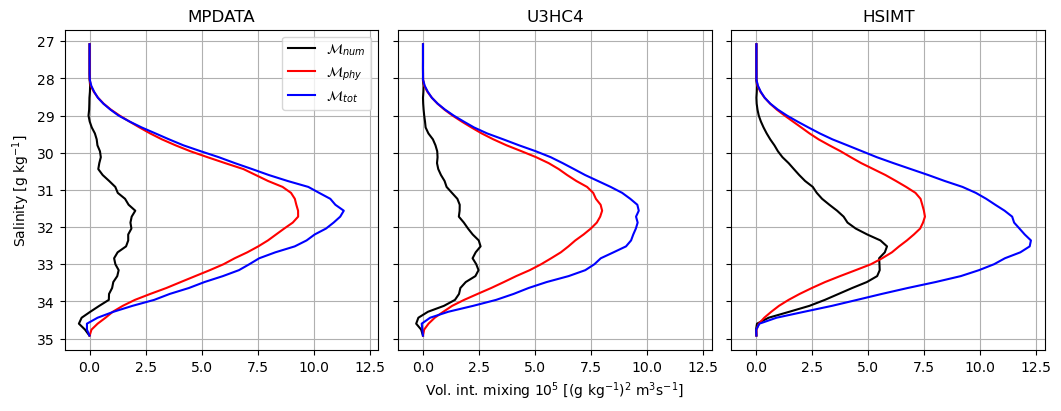

In [47]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpdata_nf.Mnum/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpdata_nf.Mphy/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpdata_nf.Mtot/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3hc4_nf.Mnum/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3hc4_nf.Mphy/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3hc4_nf.Mtot/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsimt_nf.Mnum/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsimt_nf.Mphy/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsimt_nf.Mtot/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel('Vol. int. mixing $10^5$ [(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

Text(0.5, 0, '')

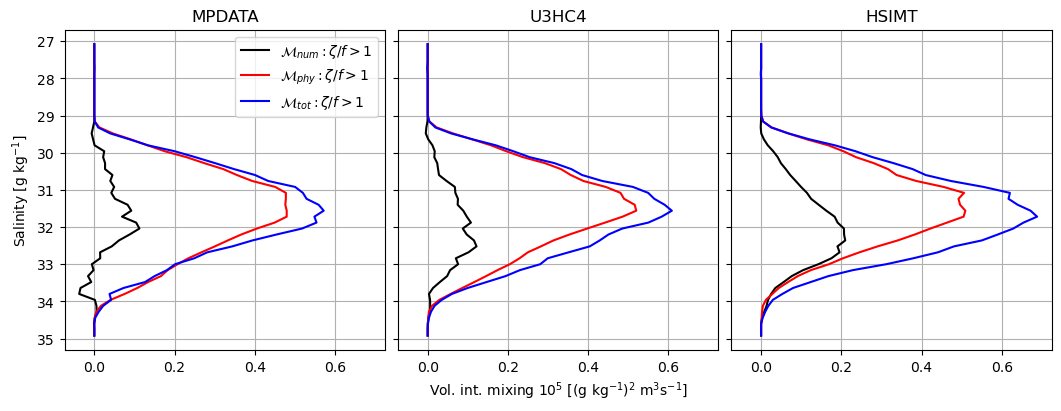

In [60]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpdata_f.Mnum/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}:\zeta/f>1$')
(mpdata_f.Mphy/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}:\zeta/f>1$')
(mpdata_f.Mtot/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}:\zeta/f>1$')

(u3hc4_f.Mnum/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3hc4_f.Mphy/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3hc4_f.Mtot/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsimt_f.Mnum/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsimt_f.Mphy/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsimt_f.Mtot/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel('Vol. int. mixing $10^5$ [(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

## Relative fraction of mixing done by fronts in each salinity bin, then calculate without xhistogram to QC calculations 

Text(0.5, 0, '')

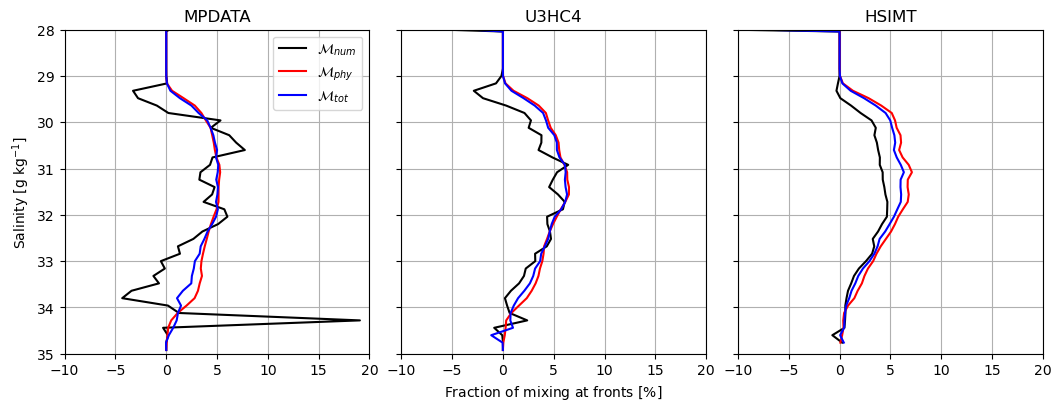

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

((mpdata_f.Mnum/mpdata_nf.Mnum)*100).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
((mpdata_f.Mphy/mpdata_nf.Mphy)*100).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
((mpdata_f.Mtot/mpdata_nf.Mtot)*100).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

((u3hc4_f.Mnum/u3hc4_nf.Mnum)*100).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
((u3hc4_f.Mphy/u3hc4_nf.Mphy)*100).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
((u3hc4_f.Mtot/u3hc4_nf.Mtot)*100).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

((hsimt_f.Mnum/hsimt_nf.Mnum)*100).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
((hsimt_f.Mphy/hsimt_nf.Mphy)*100).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
((hsimt_f.Mtot/hsimt_nf.Mtot)*100).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    ax[i].set_ylim(35,28)
    ax[i].set_xlim(-10,20)
    
ax[1].set_ylabel('')
ax[1].set_xlabel('Fraction of mixing at fronts [$\%$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

### Calculate the total fraction of mixing obtained at fronts 

In [ ]:
print(((mpdata_f.Mphy.sum(skipna=True).values))/(mpdata_nf.Mtot.sum(skipna=True)).values)
# print(((mpdata_f.Mphy.sum(skipna=True).values))/(mpdata_nf.Mphy.sum(skipna=True)).values)
# print(((mpdata_nf.Mnum.sum(skipna=True).values))/(mpdata_nf.Mtot.sum(skipna=True)).values)

0.03566298694751783


## Plot mixing per salinity class 

Text(0.5, 0, '')

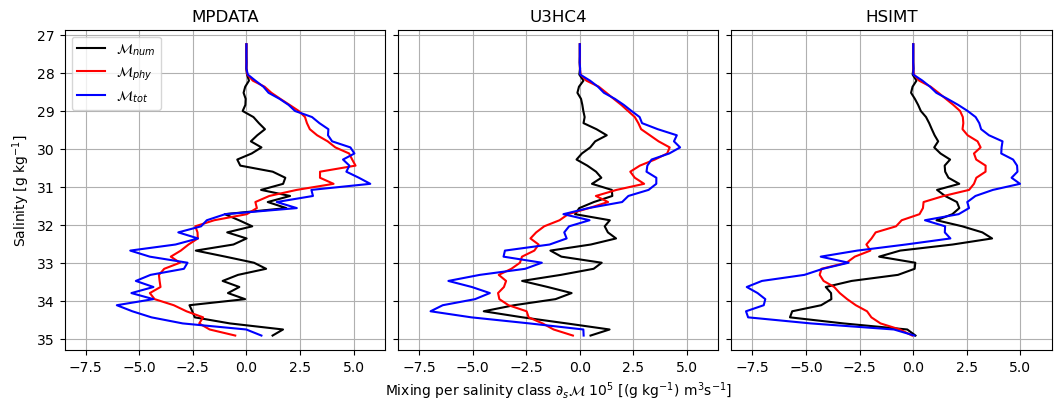

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpdata_nf.mnum/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpdata_nf.mphy/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpdata_nf.mtot/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3hc4_nf.mnum/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3hc4_nf.mphy/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3hc4_nf.mtot/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsimt_nf.mnum/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsimt_nf.mphy/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsimt_nf.mtot/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Mixing per salinity class $\partial_s \mathcal{M}$ $10^5$ [(g kg$^{-1}$) m$^3$s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

Text(0.5, 0, '')

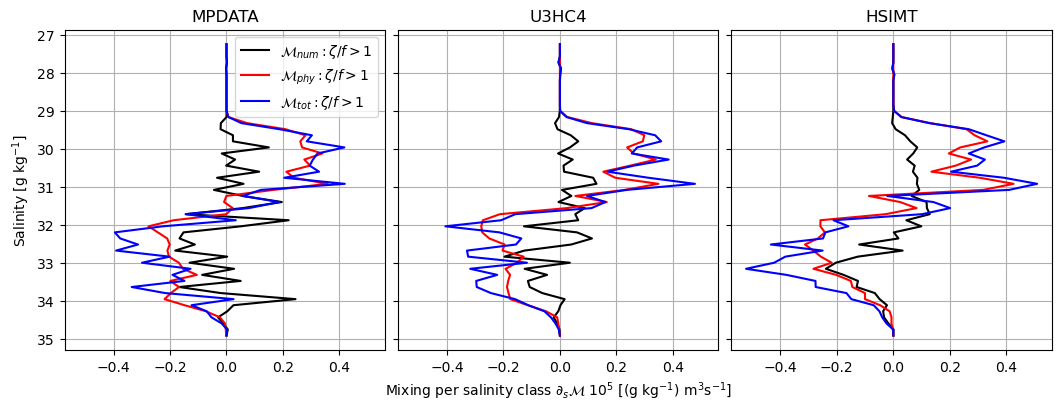

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpdata_f.mnum/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}: \zeta/f>1$')
(mpdata_f.mphy/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}: \zeta/f>1$')
(mpdata_f.mtot/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}: \zeta/f>1$')

(u3hc4_f.mnum/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3hc4_f.mphy/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3hc4_f.mtot/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsimt_f.mnum/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsimt_f.mphy/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsimt_f.mtot/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Mixing per salinity class $\partial_s \mathcal{M}$ $10^5$ [(g kg$^{-1}$) m$^3$s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

## Plot integrated diffusive salt flux per salinity class 

Text(0.5, 0, '')

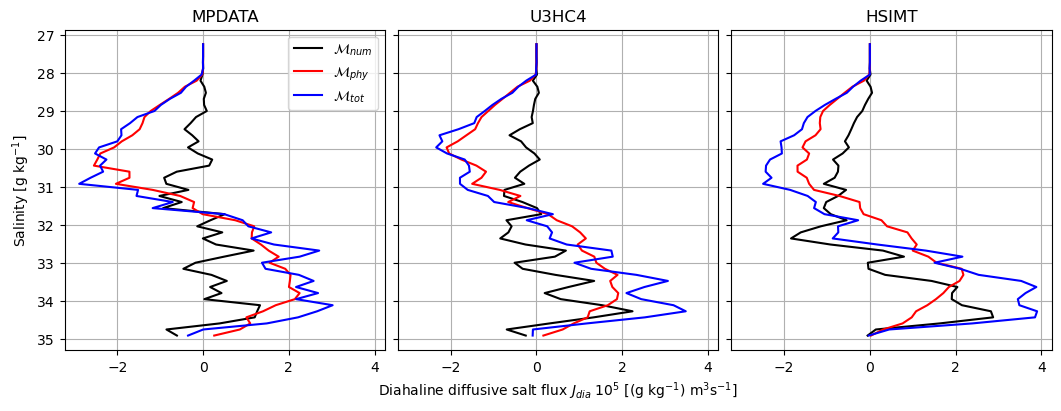

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpdata_nf.jdia_num/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpdata_nf.jdia_phy/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpdata_nf.jdia_tot/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3hc4_nf.jdia_num/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3hc4_nf.jdia_phy/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3hc4_nf.jdia_tot/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsimt_nf.jdia_num/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsimt_nf.jdia_phy/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsimt_nf.jdia_tot/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Diahaline diffusive salt flux $J_{dia}$ $10^5$ [(g kg$^{-1}$) m$^3$s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

### Plot the integrated diahaline volume flux 

Text(0.5, 0, '')

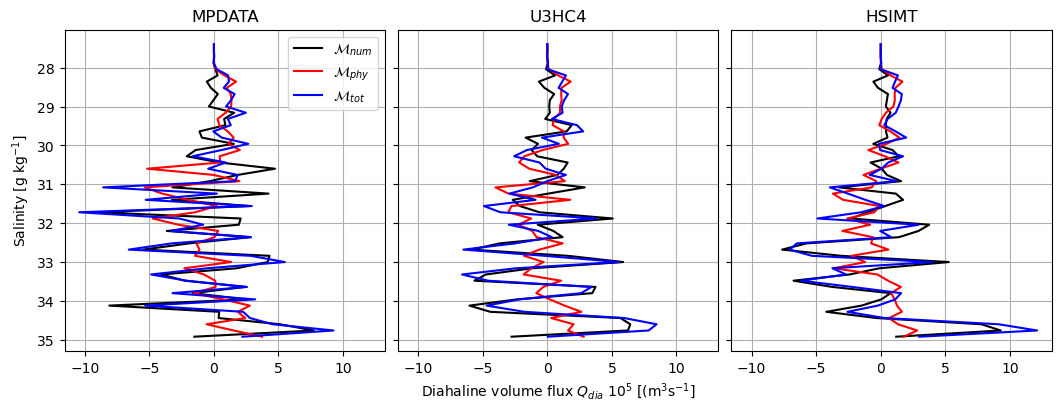

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpdata_nf.Qdia_num/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpdata_nf.Qdia_phy/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpdata_nf.Qdia_tot/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3hc4_nf.Qdia_num/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3hc4_nf.Qdia_phy/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3hc4_nf.Qdia_tot/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsimt_nf.Qdia_num/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsimt_nf.Qdia_phy/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsimt_nf.Qdia_tot/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Diahaline volume flux $Q_{dia}$ $10^5$ [(m$^3$s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

Text(0.5, 0, '')

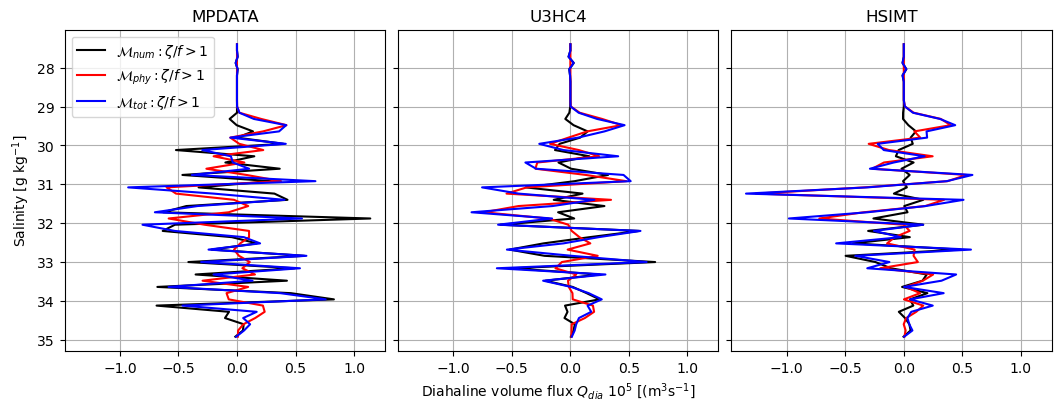

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpdata_f.Qdia_num/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}: \zeta/f>1$')
(mpdata_f.Qdia_phy/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}: \zeta/f>1$')
(mpdata_f.Qdia_tot/10**5).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}: \zeta/f>1$')

(u3hc4_f.Qdia_num/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3hc4_f.Qdia_phy/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3hc4_f.Qdia_tot/10**5).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsimt_f.Qdia_num/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsimt_f.Qdia_phy/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsimt_f.Qdia_tot/10**5).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Diahaline volume flux $Q_{dia}$ $10^5$ [(m$^3$s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

In [64]:
print(mpdata_nf.Qdia_num.sum().values/(mpdata_nf.Qdia_tot.sum().values))
print(mpdata_f.Qdia_num.sum().values/(mpdata_f.Qdia_tot.sum().values))

print(u3hc4_nf.Qdia_num.sum().values/(u3hc4_nf.Qdia_tot.sum().values))
print(u3hc4_f.Qdia_num.sum().values/(u3hc4_f.Qdia_tot.sum().values))

print(hsimt_nf.Qdia_num.sum().values/(hsimt_nf.Qdia_tot.sum().values))
print(hsimt_f.Qdia_num.sum().values/(hsimt_f.Qdia_tot.sum().values))
# print(Qdia_phy.sum().values/(Qdia_tot.sum().values))

# print(Qdia_num_f.sum().values/(Qdia_tot_f.sum().values))
# print(Qdia_phy_f.sum().values/(Qdia_tot_f.sum().values))

1.7437458617870054
-0.6535908178604826
2.8105687866425026
-0.8480104637580372
1.9154901192033953
1.1625885571335326


### For each scheme, numerical mixing introduces a massive amount of diahaline volume transport 